# TAOS drifter deployments: tool development

[Marc](https://marc.ifremer.fr/resultats/courants/modeles_mars2d_atlantique_nord_est/(variable)/courant/(typevisu)/map/(zoneid)/7418/(type)/canvas#appTop)


In [1]:
import os
from glob import glob

from datetime import datetime
import time

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import minimize, Bounds

import matplotlib.pyplot as plt
import pyproj

import urllib.request

import taos.utils as ut

rad2deg = 180./np.pi
knot = 0.514
one_second = pd.Timedelta("1s")


now = lambda: pd.to_datetime(datetime.utcnow())


lonc, latc = -0.4, 49.5

In [2]:
ut.metrics_cheatsheet(lonc, latc)

 lon: 1 deg = 72.44km,  0.1 deg = 7.2km,  0.01 deg = 724.4m,  0.001 deg = 72.4m
 lon: 1 deg = 72.44km,  1 min = 1207.3m,  .1 min = 120.7m,  0.01 min = 12.1m
 lon: 1 deg = 72.44km,  1 sec = 20.1m,  .1 sec = 2.0m
-----------------------------------------------------------------
 lat: 1 deg = 111.23km,  0.1 deg = 11.1km,  0.01 deg = 1112.2m,  0.001 deg = 111.2m
 lat: 1 deg = 111.23km,  1 min = 1853.7m,  .1 min = 185.4m,  0.01 min = 18.5m
 lat: 1 deg = 111.23km,  1 sec = 30.9m,  .1 sec = 3.1m


In [3]:
proj = pyproj.Proj(proj="aeqd", lat_0=latc, lon_0=lonc, datum="WGS84", units="m")

def ll2xy(lon, lat):
    return proj.transform(lon, lat)
    
def xy2ll(x, y):
    _inv_dir = pyproj.enums.TransformDirection.INVERSE
    return proj.transform(x, y, direction=_inv_dir)

# checks: (lonc, latc) is mapped to (0,0)
# (lonc, latc), ll2xy(lonc, latc), xy2ll(*ll2xy(lonc, latc))


🐷🐷🐷🐷🐨🌼🌼🌼💐💐🌾🌖🌾😋😋👩‍🦳👩‍🦳§😄😁😁😁😀😄😄(😃😄(😚😚😗)🙃😇😇😇😇🥳🥳😏🥳🥳😏🥳😏🥳)😡😡😡😡😡😡👹👹👹👺👺👺👾👽👾😿😿😿😸😹👍🖐🏻👉🏽👀👥👥👥👥👥👥👥🧑🏽‍🦰🧑🏽‍🦰👱‍♂️👱‍♂️👱‍♂️👱‍♂️😡🤕à🤕🤕🤒😷

---

## course resolution 

In [4]:
L = 1e3
(-0.25, 49.33)
(-0.25, 49.37)

(-0.25, 49.37)

\begin{align}
\delta_x + u_o (\delta t + t_w) = u_s \cos(\theta) \delta t, \\
\delta_y + v_o (\delta t + t_w) = u_s \sin(\theta) \delta t,
\end{align}

\begin{align}
\delta_x + u_o t_w = (u_s \cos(\theta) - u_o ) \delta t, \\
\delta_y + v_o t_w = (u_s \sin(\theta) - v_o ) \delta t,
\end{align}


Positions of next point:

\begin{align}
x_0 + u_s \cos(\theta) \delta t, \\
y_0 + u_s \sin(\theta) \delta t,
\end{align}




In [5]:
from scipy import optimize

def _match(x, dX, Uo, speed, t_wait):
    theta, dt = x
    Us = speed*np.exp(1j*theta)
    return np.abs( dX + Uo*(dt + t_wait) - Us*dt )

def solve_route_heading(dX, speed, Uo, time_waiting, **kwargs):
    """ Solve where we need to head given:
    
    Parameters
    ----------
    dX: complex
        distance relative to initial point
    speed: float
        ship speed (m/s)
    Ui: complex
        ocean current (m/s)
    time_waiting: float
        time we wish to wait at the deployment point (seconds)
    ...
    """

    # local optimization
    #bounds = Bounds([-2*np.pi, 2*np.pi], [0., np.inf])
    # https://docs.scipy.org/doc/scipy/reference/optimize.html#local-multivariate-optimization
    #minopts = dict(method='trust-constr', bounds=bounds)
    #minopts = dict(bounds=bounds)
    #minopts.update(**kwargs)
    #res = minimize(_match, [np.angle(dX), time_waiting], args=(dX, Uo, speed, time_waiting), **minopts)

    # global optimization
    bounds = [(-1.1*np.pi, np.pi), (1., 3600*10)]
    minopts = dict(sampling_method='sobol') # options=dict(f_tol=1), 
    minopts.update(**kwargs)
    res = optimize.shgo(_match, bounds, (dX, Uo, speed, time_waiting), **minopts)

    theta, dt_route = res["x"]
    Us = speed*np.exp(1j*theta)
    X_launch = Us*dt_route
    
    return theta, dt_route, dt_route+time_waiting, X_launch, Us

def solve_route_heading_xr(label, *args):
    """ wrapper around solve_route_heading that spits a dataset instead"""
    theta, dt_route, dt_total, X_launch, _ = solve_route_heading(*args)
    ds = xr.Dataset(dict(theta=(("route",), [theta*rad2deg]),
                         dt_route=(("route",), [pd.Timedelta(seconds=dt_route)]),
                         dt_total=(("route",), [pd.Timedelta(seconds=dt_total)]),
                         X_launch=(("route",), [X_launch]),
                        )
                   )
    return ds

In [6]:
Uo = .5 + 1j*0 # m/s
dX = 0 - 1j*1e3 # m
speed = 10*0.5 # m/s
time_waiting = 5*60 # seconds

theta, dt, _, X_launch, Us = solve_route_heading(dX, speed, Uo, time_waiting)

print(f" New heading = {theta*rad2deg:.1f} at {speed/knot:.1f} knots ({speed:.1f}m/s), time to destination = {dt/60:.1f}min, waiting time: {time_waiting/60:.1f}min")

/Users/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 New heading = -75.8 at 9.7 knots (5.0m/s), time to destination = 3.4min, waiting time: 5.0min


In [7]:
def plot_route_solution(dX, Us, Uo, dt, time_waiting):

    fig, ax = plt.subplots(1,1)

    opt = {'head_width': 50, 'head_length': 50, 'width': 20, 'length_includes_head': False}

    ax.arrow(0, 0, dX.real, dX.imag, fc="k", **opt)
    ax.arrow(0, 0, (dt)*Uo.real, (dt)*Uo.imag, fc="b", **opt)
    ax.arrow(0, 0, (dt+time_waiting)*Uo.real, (dt+time_waiting)*Uo.imag, fc="b", **opt)
    ax.arrow(0, 0, dt*Us.real, dt*Us.imag, fc="orange", **opt)

    ax.set_aspect("equal")
    ax.grid()

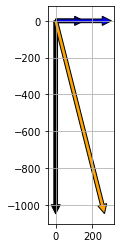

In [8]:
plot_route_solution(dX, Us, Uo, dt, time_waiting)

In [9]:
def build_polygon(L, theta, N, rotation=1):
    X = L*(np.exp(rotation*1j*2*np.arange(N)*np.pi/N) - 1) * np.exp(1j*theta)
    dX = np.diff(X)
    return X, dX

def build_square_with_center(L, theta, rotation=1, center_loc=1):
    X, _ = build_polygon(L, theta, 4, rotation=rotation)
    X = np.insert(X, center_loc, X.mean())
    return X, np.diff(X)

def plot_polygon(X, dX):
    """ plot polygon """
    fig, ax = plt.subplots(1,1)
    ax.scatter(X.real, X.imag, s=300, marker=".")

    opt = {'head_width': 50, 'head_length': 50, 'width': 10, 'length_includes_head': False}

    for i in range(len(X)-1):
        ax.arrow(X[i].real, X[i].imag, dX[i].real, dX[i].imag, fc="k", **opt)

    for i in range(X.size):
        ax.text(X[i].real+100, X[i].imag, f"{i}")    

    ax.set_aspect("equal")
    ax.grid()

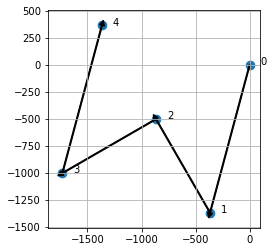

In [10]:
L, theta, N = 1e3, 30/rad2deg, 5
#X, dX = build_polygon(L, theta, N, rotation=1)
X, dX = build_square_with_center(L, theta, rotation=-1, center_loc=2)
plot_polygon(X, dX)

In [11]:
def build_square_geo(lon_a, lat_a, L, theta, **kwargs):
    """build square geographic coordinates, along with other useful informations"""
    # convert lon/lat to local coordinates
    x_a, y_a = ll2xy(lon_a, lat_a)
    # build polygon
    X, dX = build_square_with_center(L, theta, **kwargs)
    # offset local coordinates and compute lon/lat
    x, y = x_a+X.real, y_a+X.imag
    lon, lat = xy2ll(x, y)
    return lon, lat, x, y, dX

In [12]:
# anchor point
lon_a, lat_a = -0.25, 49.33
lon, lat, x, y, dX = build_square_geo(lon_a, lat_a, L, theta, rotation=-1, center_loc=2)

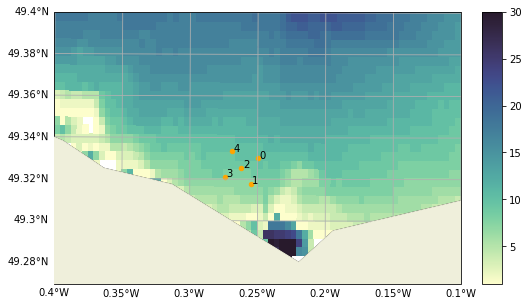

In [13]:
fac = ut.plot_bs(bathy=False, zoom=[-.4, -.1, 49.27, 49.4], vmax=30)
ax = fac["ax"]

ax.scatter(lon, lat, 20, color="orange", transform=ut.ccrs.PlateCarree())

for i in range(lon.size):
    ax.text(lon[i]+1e-3, lat[i], f"{i}", transform=ut.ccrs.PlateCarree())    

ax.set_aspect("equal")
ax.grid()

In [19]:
### solve route

def schedule_route(dX, Uo, speed, time_waiting, delta = "5min"):
    """
    
    could also update positions based on more recent ones
    """

    S = []

    # First launch is treated separately
    # time when first drifter will be launched
    time_last_position = now() # time where last position was recorded, to be updated
    delta_t = pd.Timedelta(delta)
    time_launch = (now() + delta_t).ceil(delta)
    # position is updated at launch time
    _dt = (time_launch - time_last_position)/one_second
    dx, dy = Uo.real*_dt, Uo.imag*_dt
    x_launch, y_launch = x[0]+dx, y[0]+dy
    lon_launch, lat_launch = xy2ll(x_launch, y_launch)
    # store
    S.append(pd.Series(dict(time=time_launch, x=x_launch, y=y_launch, lon=lon_launch, lat=lat_launch)))

    # following launches
    for i in range(dX.size):
        # could also update velocity depending on time_launch
        theta_route, dt_route, dt_total, X_launch, Us = solve_route_heading(dX[i], speed, Uo, time_waiting)
        # update launch position and time
        x_launch += X_launch.real
        y_launch += X_launch.imag
        time_launch += dt_total*one_second
        lon_launch, lat_launch = xy2ll(x_launch, y_launch)
        # store
        S.append(pd.Series(dict(time=time_launch, x=x_launch, y=y_launch, lon=lon_launch, lat=lat_launch)))

    # concatenate results
    df = pd.DataFrame(S)
    
    return df


def plot_route(lon, lat, df):

    fac = ut.plot_bs(bathy=False, zoom=[-.3, -.2, 49.29, 49.36], vmax=30, figsize=(10,10))
    ax = fac["ax"]

    ax.scatter(lon, lat, 40, color="orange", transform=ut.ccrs.PlateCarree())
    ax.scatter(df.lon, df.lat, 40, color="red", transform=ut.ccrs.PlateCarree())

    # arrows
    transform = ut.ccrs.PlateCarree()._as_mpl_transform(ax)
    for i in range(df.index.size-1):
        ax.annotate('', xy=(df.loc[i+1, "lon"], df.loc[i+1, "lat"]), 
                    xytext=(df.loc[i, "lon"], df.loc[i, "lat"]),
                    xycoords=transform,
                    size=20,
                    arrowprops=dict(facecolor='0.5', ec = 'none', 
                                    #arrowstyle="fancy",
                                    connectionstyle="arc3,rad=-0.3"),
                   )

    # labels
    for i in range(lon.size):
        ax.text(lon[i]+1e-3, lat[i], f"{i}", transform=ut.ccrs.PlateCarree())   

    ax.set_aspect("equal")
    ax.grid()

/Users/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


,time,x,y,lon,lat
0,2022-05-07 18:55:00.000000000,11086.120015,-18896.177533,-0.247482,49.329997
1,2022-05-07 19:18:12.913066276,11050.525740,-21628.228340,-0.248047,49.305432
2,2022-05-07 19:35:12.923603547,10560.531010,-19896.177532,-0.254739,49.321015
3,2022-05-07 19:50:56.453865114,9300.245332,-20896.177530,-0.272098,49.312044
4,2022-05-07 20:16:44.304191517,10806.221304,-18164.126724,-0.251313,49.336584


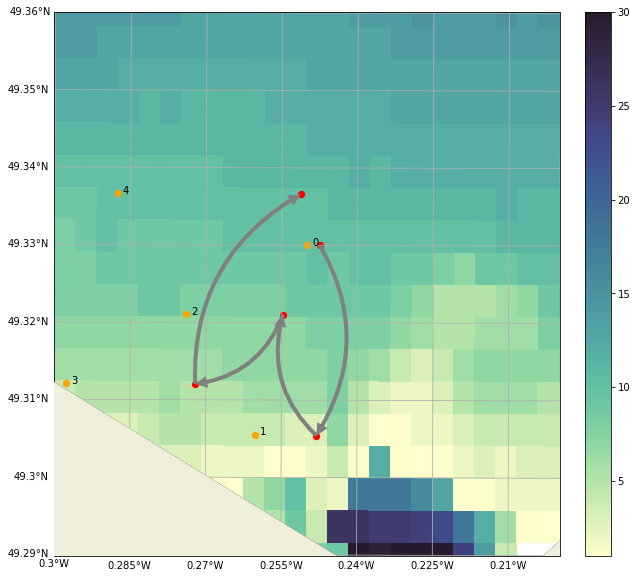

In [23]:
# anchor point
L, theta = 2e3, 30/rad2deg
lon_a, lat_a = -0.25, 49.33

Uo = .5 + 1j*0 # m/s
#dX = 0 - 1j*1e3 # m
speed = 5*0.5 # m/s
time_waiting = 5*60 # seconds

lon, lat, x, y, dX = build_square_geo(lon_a, lat_a, L, theta, rotation=-1, center_loc=2)

df = schedule_route(dX, Uo, speed, time_waiting)

plot_route(lon, lat, df)
df

In [354]:
# debug
if False:
    fig, ax = plt.subplots(1,1)

    ax.scatter(x, y, 10, color="orange")
    ax.scatter(df.x, df.y, 20, color="red")

    ax.set_aspect("equal")
    ax.grid()

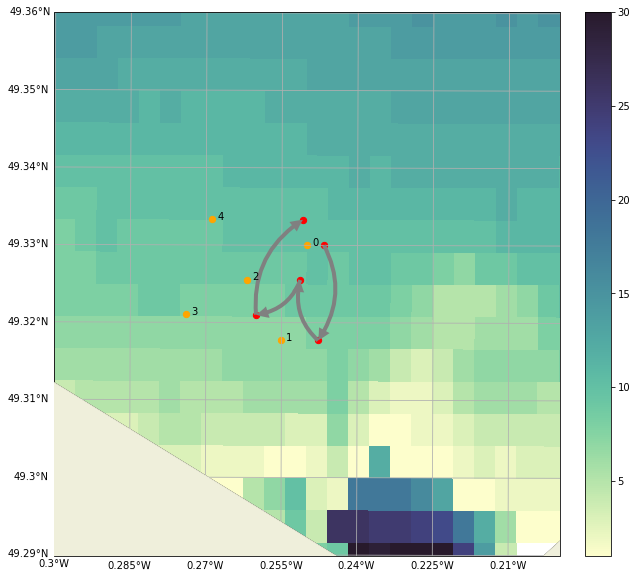

In [371]:
# debug
if False:
    #opts = dict(n=256, options=dict(disp=True))
    #opts = dict(n=512)
    _dX = dX[0]
    theta, dt_route, dt_total, X_launch, Us = solve_route_heading(_dX, speed, Uo, time_waiting)
    plot_route_solution(_dX, Us, Uo, dt_route, time_waiting)
    theta*rad2deg, dt_route/60, dt_total/60, X_launch, Us

---
## load drifter data

😹🧑🏽‍🦰🧑🏽‍🦰😸👺👺😍😍😌😍🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰😒😒😒😫😫😫😫😫😫😩😩😩😩😩😩😩😫😫😫😫😫😫😫😫😫😫😫🥵😬😬😬🙄🙄🙄🙄🙄😬😑😐🥶🥶🥶🥶🥶🥶🥶🥶😱😱😱😱🥵🥵🥶🥵🥵🥵🥵🥵🥵🥵🤮🥴🥴🤧🤧👶👶👶👶👥👥

🥶🥶🥶😚c😚😚😋🥅🥅🥅🥅🥊🥊🥊🥊🥊🥊🥊🥊🛷🛷🛷🛷🛷🛷🪂🪂🪂🪂🪂🪂🪂🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🎽🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷m🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿⛷⛷⛷⛷⛷⛷🛹🛹🛹🛹🛹🛹🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸⛹️‍♂️⛹️‍♂️⛹🏻‍♀️⛹️‍♂️🤺🤺🤺


In [14]:


def fetch_drifter_data(timestamp=True, verbose=True):

    with open('pacific_url', 'r') as f:
        # do things with your file
        url = f.read().strip()

    if timestamp:
        t = now()
        tstamp = "_"+t.strftime("%Y%m%d_%H%M%S")
    else:
        tstamp = ""
    file = "drifter_data"+tstamp+".csv"
        
    urllib.request.urlretrieve(url, file)
    print(f" Drifter data downloaded as {file}")
    
def find_latest_drifter_file():
    """ find latest drifter file"""
    local_dir = os.getcwd()
    drifter_files = glob(os.path.join(local_dir,"drifter_data*.csv"))
    mtimes = [os.path.getmtime(f) for f in drifter_files]
    latest_file = drifter_files[mtimes.index(max(mtimes))]
    return latest_file

In [14]:
fetch_drifter_data()

 Drifter data downloaded as drifter_data_20220507_112739.csv


In [17]:
def load_drifter_data(file=None):
    """Load drifter data into a dict of dataframes"""
    if file is None:
        file = find_latest_drifter_file()
    df = pd.read_csv(file, parse_dates=["DeviceDateTime"])
    dr = {k: v.sort_values("DeviceDateTime") for k, v in df.groupby("CommId")}
    for k, v in dr.items():
        # compute local coordinates x, y
        v.loc[:,["x", "y"]] = v.apply(lambda r: pd.Series(ll2xy(r["Longitude"], r["Latitude"]), index=["x","y"]),
                                      axis=1)
        # compute velocity
        #print(dr[anchor]["DeviceDateTime"].diff()/pd.Timedelta("1s"))
        v.loc[:,"dt"] = v.DeviceDateTime.diff()/pd.Timedelta("1s")
        v.loc[:,"u"] = v.x.diff()/v.dt
        v.loc[:,"v"] = v.y.diff()/v.dt
        dr[k] = (v.rename(columns=dict(Longitude="longitude", Latitude="latitude", DeviceDateTime="time"))
                 .set_index("time")
                )
    return dr

def extrapolate_one(df, time):
    dfl = df.reset_index().iloc[-1]
    time_last = dfl.time
    dt = (time - time_last)/pd.Timedelta("1s")
    #
    dx, dy = dfl.u*dt, dfl.v*dt
    x, y = dfl.x+dx, dfl.y+dy
    #
    lon, lat = xy2ll(x, y)
    return pd.Series(dict(time=time, longitude=lon, latitude=lat, x=x, y=y))

def extrapolate(dr, time=None):
    """extrapolate drifter position to new one"""
    if time is None:
        time = now()
    return {k: extrapolate_one(df, time) for k, df in dr.items()}

In [18]:
dr = load_drifter_data()
anchor = "0-4351896"
dr_now = extrapolate(dr)

In [ ]:
from ipywidgets import GridspecLayout

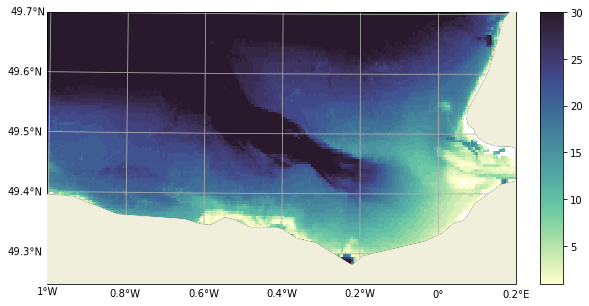

In [19]:
fac = ut.plot_bs(bathy=False, zoom=1, vmax=30)